In [2]:
from Binaries import *

Text(0, 0.5, 'Trigger rate / Hz')

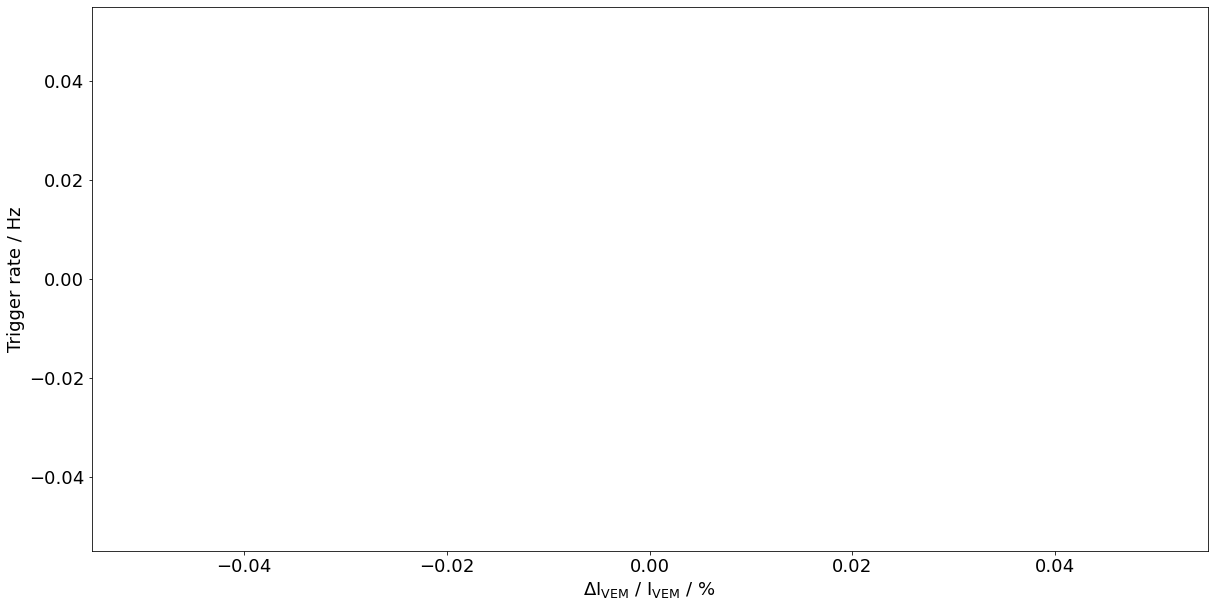

In [14]:
r_th2, r_tot, r_totd = [], [], []
e_th2, e_tot, e_totd = [], [], []
x, r_total = [], []
e_total = []

for file in os.listdir("./trigger_output"):

    t, th2, tot, tod = np.loadtxt("/cr/users/filip/Trigger/RunProductionTest/trigger_output/" + file, unpack = True, usecols = [2,4,5,6])

    p = file.split("_")[-1][:-5]
    x.append(float(p[1:]) if p[0] == "p" else -1 * float(p[1:]))

    duration = t.sum()
    rate_th2 = th2.sum() / duration
    rate_tot = tot.sum() / duration
    rate_tod = tod.sum() / duration
    error_th2 = np.std(th2)
    error_tot = np.std(tot)
    error_tod = np.std(tod)

    r_th2.append(rate_th2)
    r_tot.append(rate_tot)
    r_totd.append(rate_tod)
    r_total.append(rate_total)

    rate_total = rate_th2 + rate_tot + rate_tod
    error_total = np.sqrt(error_th2**2 + error_tot**2 + error_tod**2)
    
    e_th2.append(error_th2 / duration)
    e_tot.append(error_tot / duration)
    e_totd.append(error_tod / duration)
    e_total.append(error_total / duration)

plt.errorbar(x, r_th2, yerr = e_th2)

plt.xlabel(r"$\Delta$I$_\mathrm{VEM}$ / I$_\mathrm{VEM}$ / %")
plt.ylabel("Trigger rate / Hz")

# TODO

In [13]:
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["font.size"] = 25